In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from scoobscc.math_module import xp, xcipy, ensure_np_array
from scoobscc.imshows import imshow1, imshow2, imshow3
from scoobscc import utils
from scoobscc import iefc
from scoobscc import wfe
import scoobscc.scoob_model as scoobm

wavelength_c = 633e-9*u.m

/opt/conda/envs/py310-scoob-env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


SCoOB interface does not have the required packages to operate.
Could not import ray. Parallelized model unavailble.


In [2]:
reload(scoobm)
M = scoobm.single()

Could not import ray. Parallelized model unavailble.


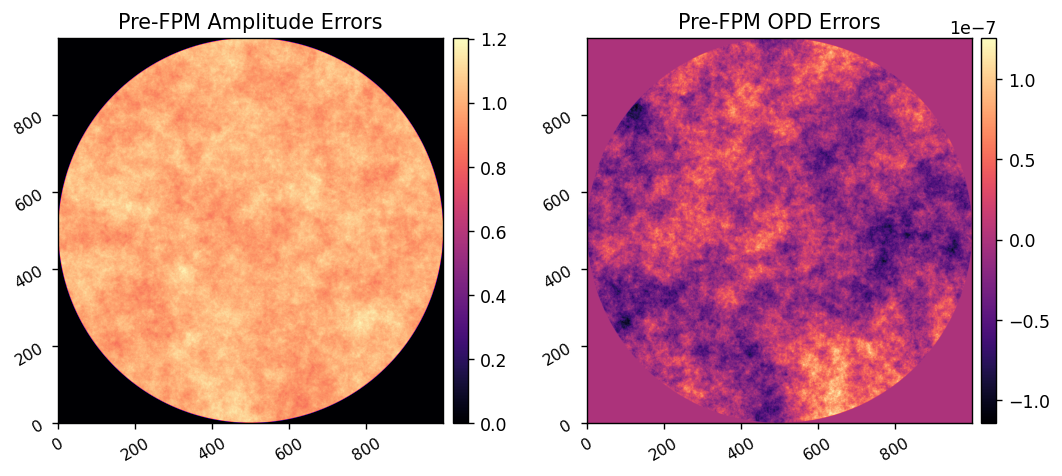

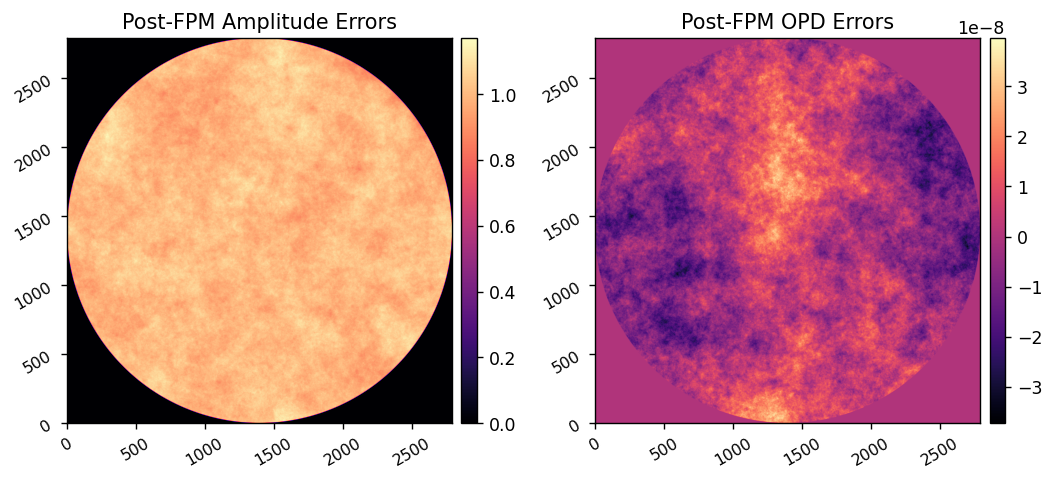

3.018617267219001e-08


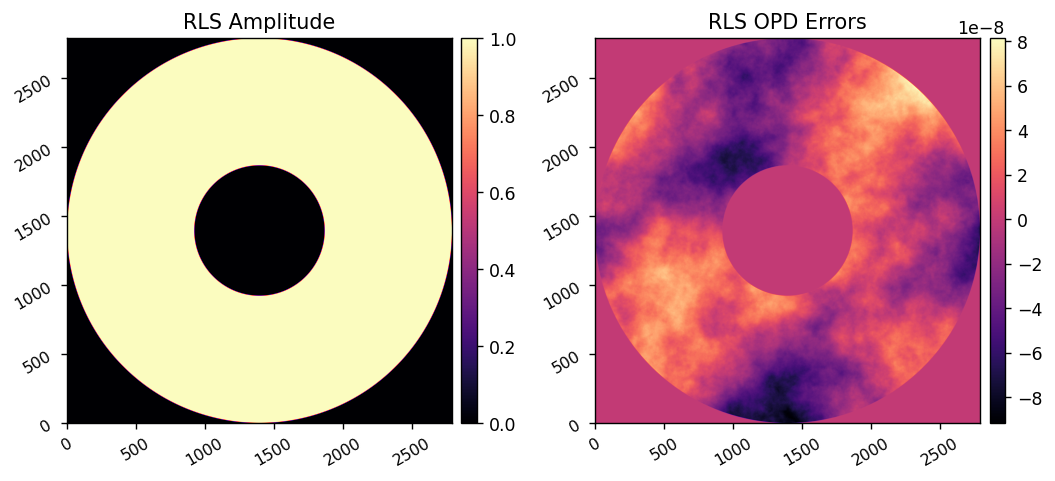

In [3]:
reload(utils)
npix = 1000

prefpm_slope = 2.5
prefpm_opd_rms = 30*u.nm
prefpm_amp_rms = 0.05
prefpm_wfe_amp, prefpm_wfe_opd = wfe.generate_wfe(
    npix=M.npix, 
    oversample=1,
    wavelength=M.wavelength_c,
    opd_index=prefpm_slope, amp_index=prefpm_slope,
    opd_rms=prefpm_opd_rms, 
    amp_rms=prefpm_amp_rms,
    remove_amp_modes=12,
    remove_opd_modes=3,
    opd_seed=12, 
    amp_seed=123,
)
imshow2(
    prefpm_wfe_amp, prefpm_wfe_opd,
    'Pre-FPM Amplitude Errors', 'Pre-FPM OPD Errors',
)

postfpm_slope = 2.5
postfpm_opd_rms = 10*u.nm
postfpm_amp_rms = 0.05
postfpm_wfe_amp, postfpm_wfe_opd = wfe.generate_wfe(
    npix=M.npix_rls, 
    oversample=1,
    wavelength=M.wavelength_c,
    opd_index=postfpm_slope, amp_index=postfpm_slope,
    opd_rms=postfpm_opd_rms, 
    amp_rms=postfpm_amp_rms,
    remove_amp_modes=12,
    remove_opd_modes=3,
    opd_seed=1234, 
    amp_seed=12345,
)
imshow2(
    postfpm_wfe_amp, postfpm_wfe_opd, 
    'Post-FPM Amplitude Errors', 'Post-FPM OPD Errors',
)

rls_slope = 3.5
rls_opd_rms = 30*u.nm
rls_wfe_amp, rls_wfe_opd = wfe.generate_wfe(
    npix=M.npix_rls, 
    oversample=1,
    wavelength=M.wavelength_c,
    opd_index=rls_slope, amp_index=rls_slope,
    opd_rms=rls_opd_rms, 
    amp_rms=0.00,
    remove_amp_modes=12,
    remove_opd_modes=3,
    opd_seed=123456, 
    amp_seed=1234567,
)
rls_mask = utils.pad_or_crop(M.RLS, M.npix_rls) > 0
rls_wfe_amp *= utils.pad_or_crop(M.RLS, M.npix_rls)
rls_wfe_opd *= utils.pad_or_crop(M.RLS, M.npix_rls)
rls_wfe_opd_rms = xp.sqrt( xp.mean( xp.square( rls_wfe_opd[rls_mask] )))
print(rls_wfe_opd_rms)
rls_wfe_opd *= rls_opd_rms.to_value(u.m) / rls_wfe_opd_rms
rls_wfe_opd = xp.rot90(rls_wfe_opd)
imshow2(
    rls_wfe_amp, rls_wfe_opd, 
    'RLS Amplitude', 'RLS OPD Errors',
)

In [4]:
M.Nrls, M.npix_rls

(3000, 2791)

In [5]:
reload(scoobm)
M = scoobm.single()
M.PREFPM_AMP = prefpm_wfe_amp
M.PREFPM_OPD = prefpm_wfe_opd 

M.POSTFPM_AMP = postfpm_wfe_amp
M.POSTFPM_OPD = postfpm_wfe_opd 

M.RLS_AMP = rls_wfe_amp
M.RLS_OPD = rls_wfe_opd 

Could not import ray. Parallelized model unavailble.


1.0
(952,) <class 'numpy.ndarray'>


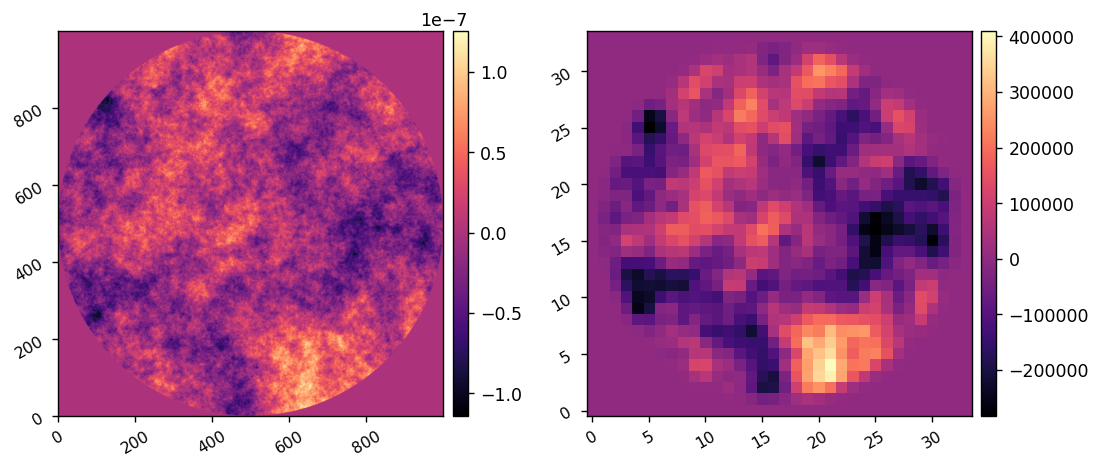

In [6]:
def val_and_grad(
        del_acts, 
        M, 
        current_acts=np.zeros((M.Nact,M.Nact)) 
    ):

    del_acts = xp.array(del_acts)
    del_command = xp.zeros((M.Nact, M.Nact))
    del_command[M.dm_mask] = xp.array(del_acts)

    current_acts = xp.array(current_acts)

    dm_command = current_acts + del_command
    dm_mft = M.Mx@dm_command@M.My
    dm_surf_fft = M.inf_fun_fft * dm_mft
    dm_surf = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(dm_surf_fft,))).real
    dm_surf = utils.pad_or_crop(dm_surf, M.npix)

    OPD = xp.array(M.PREFPM_OPD)
    opd_l2norm = OPD[M.BAP_MASK].dot(OPD[M.BAP_MASK])
    total_opd =  OPD + 2*dm_surf
    J = total_opd[M.BAP_MASK].dot(total_opd[M.BAP_MASK]) / opd_l2norm
    print(J)

    masked_total = M.APERTURE * total_opd
    dJ_dOPD = 2 * (masked_total) / opd_l2norm

    dJ_dS_DM = utils.pad_or_crop(dJ_dOPD, M.Nsurf)
    x2_bar = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dS_DM)))
    x1_bar = x2_bar * M.inf_fun_fft.conj()
    dJ_dA1 = M.Mx_back@x1_bar@M.My_back / ( M.Nsurf * M.Nact * M.Nact )

    dJ_dA = dJ_dA1[M.dm_mask].real

    return ensure_np_array(J), ensure_np_array(dJ_dA)

del_acts = xp.zeros(M.Nacts)
J0, dJ_dA = val_and_grad(del_acts, M)
print(dJ_dA.shape, type(dJ_dA))

dm_grad = xp.zeros((M.Nact, M.Nact))
dm_grad[M.dm_mask] = xp.array(dJ_dA)
imshow2(M.PREFPM_OPD, dm_grad)

1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  4.09246D+05
14444189026435.14
0.6813022958798948

At iterate    1    f=  6.81302D-01    |proj g|=  3.02507D+05
0.2546347746548723

At iterate    2    f=  2.54635D-01    |proj g|=  4.95040D+04
0.23992679833970465

At iterate    3    f=  2.39927D-01    |proj g|=  3.02819D+04
0.2217169478865265

At iterate    4    f=  2.21717D-01    |proj g|=  1.81322D+04
0.2195727185144642


 This problem is unconstrained.



At iterate    5    f=  2.19573D-01    |proj g|=  2.47516D+04
0.21725117183628698

At iterate    6    f=  2.17251D-01    |proj g|=  8.91839D+03
0.21623707722773405

At iterate    7    f=  2.16237D-01    |proj g|=  7.36542D+03
0.21545620851584824

At iterate    8    f=  2.15456D-01    |proj g|=  6.28240D+03
0.21490681952533003

At iterate    9    f=  2.14907D-01    |proj g|=  9.22977D+03
0.21435704678862572

At iterate   10    f=  2.14357D-01    |proj g|=  4.43020D+03
0.21417157856030697

At iterate   11    f=  2.14172D-01    |proj g|=  3.97470D+03
0.2139399682885402

At iterate   12    f=  2.13940D-01    |proj g|=  3.20598D+03
0.213942017000772
0.21383538678900876

At iterate   13    f=  2.13835D-01    |proj g|=  3.94792D+03
0.2137176092517448

At iterate   14    f=  2.13718D-01    |proj g|=  2.70644D+03
0.21360741814233988

At iterate   15    f=  2.13607D-01    |proj g|=  3.06858D+03
0.213610245738959
0.21355153958982043

At iterate   16    f=  2.13552D-01    |proj g|=  1.76093D+03

 

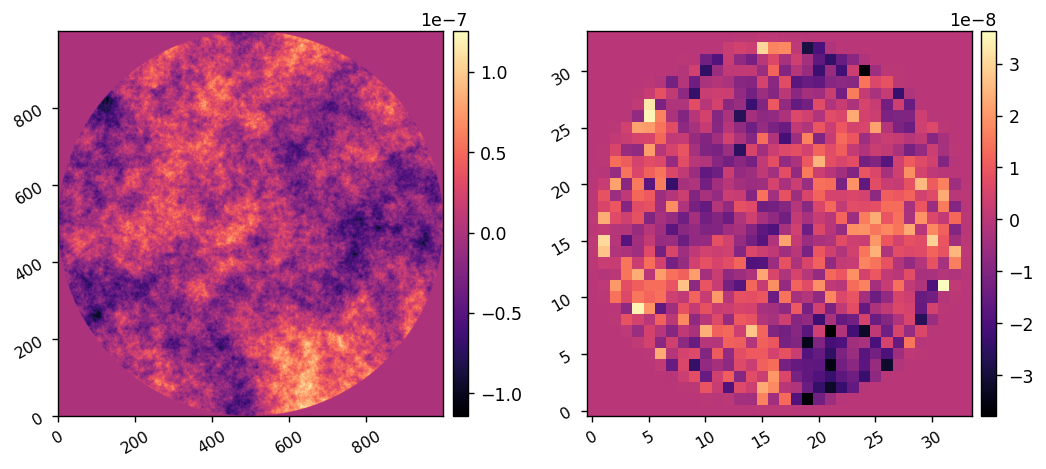

In [7]:
bfgs_tol = 1e-4
options = {
    'disp':True, 
    # 'maxiter':30,
    # 'maxls':100, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
}
del_acts0 = np.zeros(M.Nacts)
res = minimize(
    val_and_grad, 
    jac=True, 
    x0=del_acts0, 
    args=(M),
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=options,
)

flat_command = xp.zeros((M.Nact, M.Nact))
flat_command[M.dm_mask] = xp.array(res.x)
imshow2(M.PREFPM_OPD, flat_command,)

Could not import ray. Parallelized model unavailble.


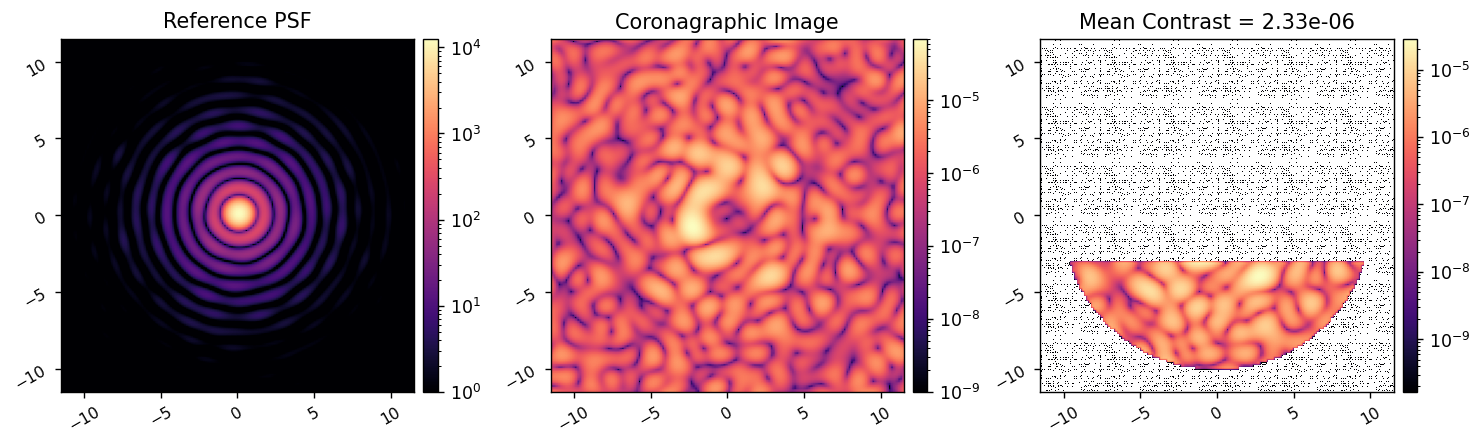

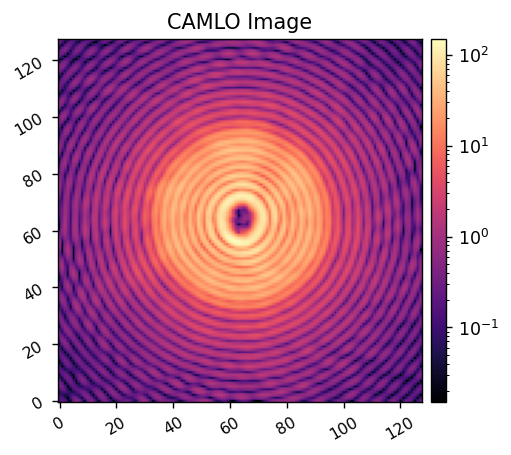

In [8]:
reload(scoobm)
reload(utils)

dm_flat_noise = 0e-9

M = scoobm.single()
M.PREFPM_AMP = prefpm_wfe_amp
M.PREFPM_OPD = prefpm_wfe_opd 

M.POSTFPM_AMP = postfpm_wfe_amp
M.POSTFPM_OPD = postfpm_wfe_opd 

M.RLS_AMP = rls_wfe_amp
M.RLS_OPD = rls_wfe_opd

M.dm_ref = flat_command + dm_flat_noise*xp.random.randn(M.Nact, M.Nact)*M.dm_mask
M.reset_dm()

iwa = 3
owa = 10
control_mask = utils.create_annular_focal_plane_mask(
    M.ncamsci, 
    M.camsci_pxscl_lamD, 
    iwa, 
    owa,  
    edge=iwa,
    rotation=90,
)

M.use_vortex = 0
ref_psf = M.snap_camsci()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = 1
camsci_im0 = M.snap_camsci()
mean_contrast = xp.mean(camsci_im0[control_mask])

imshow3(
    ref_psf, camsci_im0, camsci_im0*control_mask,
    'Reference PSF', 'Coronagraphic Image', f'Mean Contrast = {mean_contrast:.2e}', 
    pxscl=M.camsci_pxscl_lamDc,
    lognorm=1, 
    vmin1=1e0, 
    vmin2=1e-9,
)
M.ncamlo = 128
# M.ncamlo = 256
M.llowfsc_defocus = 2.75e-3
camlo_im0 = M.snap_camlo()
imshow1(camlo_im0, 'CAMLO Image', lognorm=1, vmin=xp.max(camlo_im0)/1e4)

In [9]:
wfe_data = {
    'PREFPM_AMP':prefpm_wfe_amp, 
    'PREFPM_OPD':prefpm_wfe_opd, 
    'POSTFPM_AMP':postfpm_wfe_amp, 
    'POSTFPM_OPD':postfpm_wfe_opd, 
    'RLS_AMP':rls_wfe_amp, 
    'RLS_OPD':rls_wfe_opd, 
    'DM_FLAT':M.dm_ref, 
}
utils.save_pickle('/home/derbyk/src/scoob-scc/data_sim/example_wfe_data.pkl', wfe_data)

Saved data to:  /home/derbyk/src/scoob-scc/data_sim/example_wfe_data.pkl


![Screenshot 2025-02-24 at 9.05.40 PM.png](<attachment:Screenshot 2025-02-24 at 9.05.40 PM.png>)
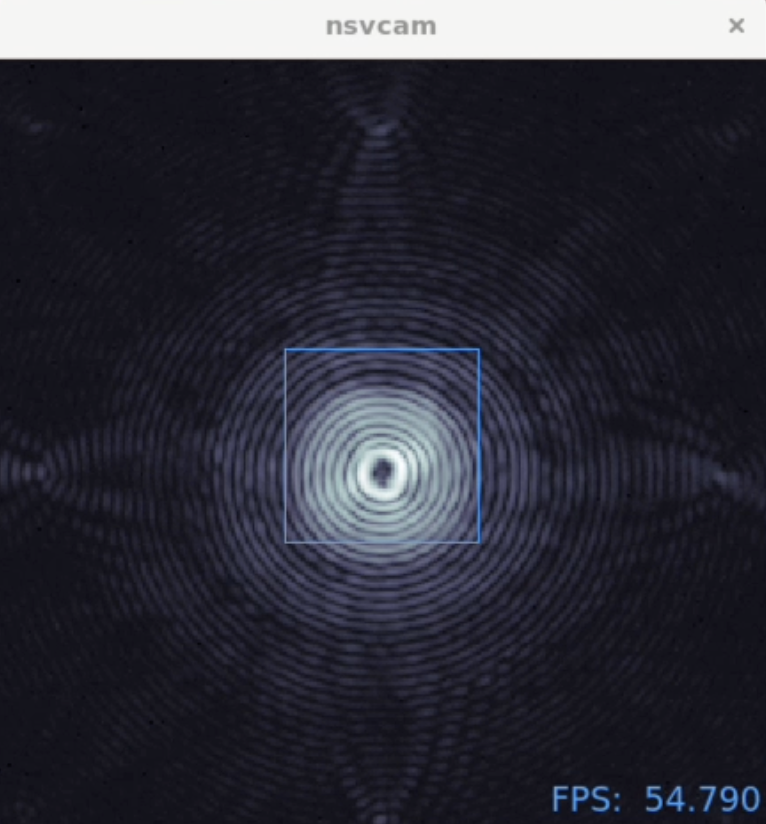

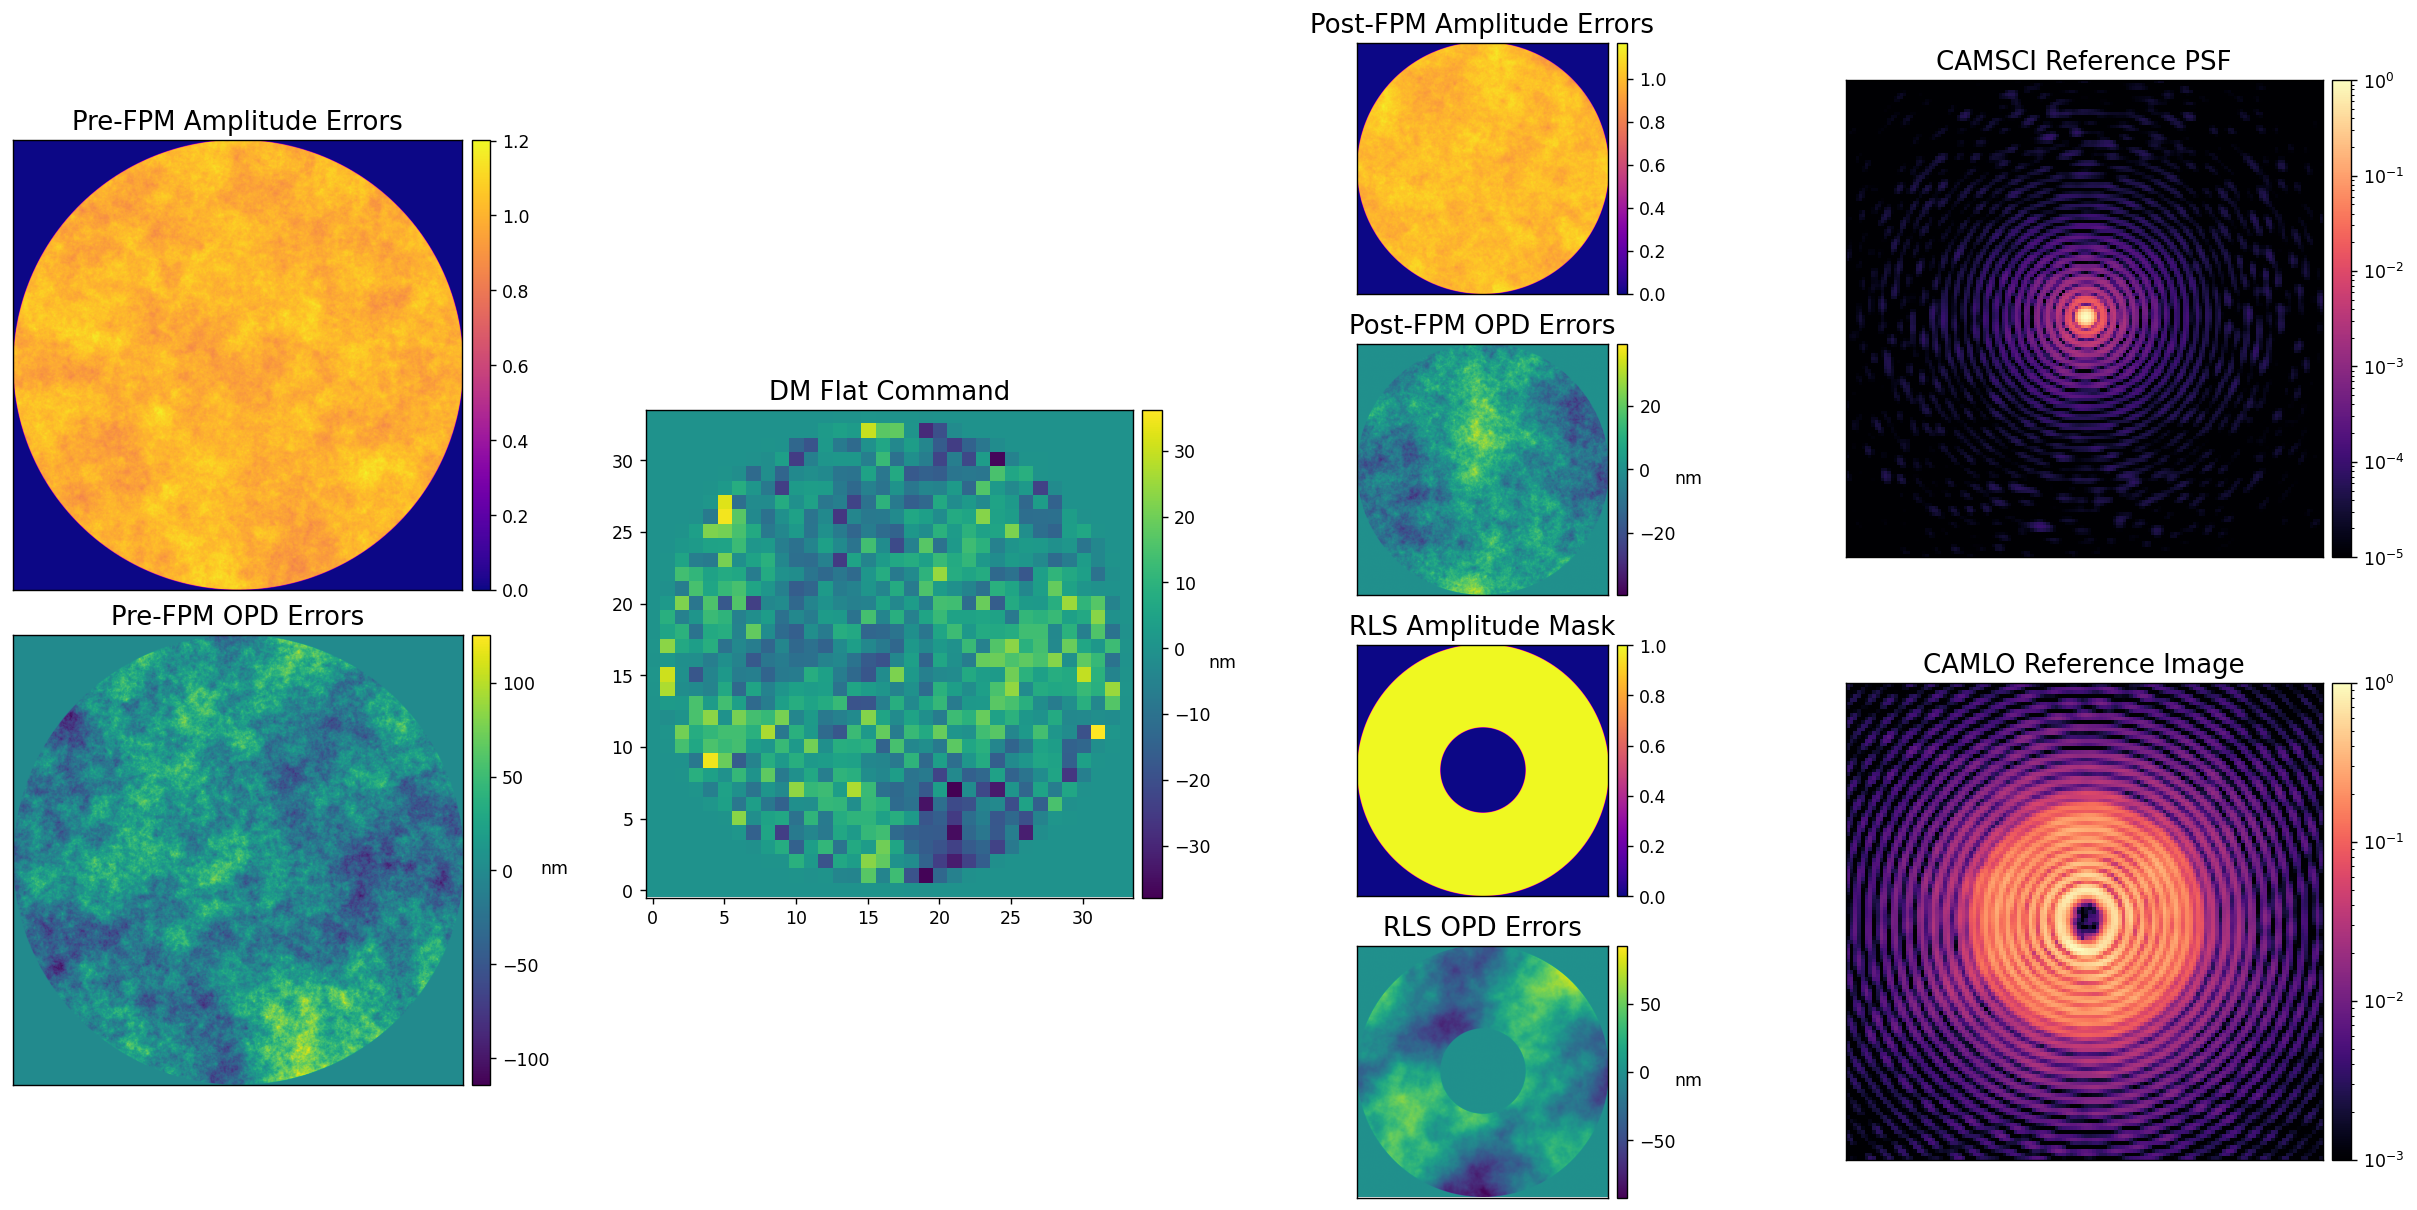

In [16]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, CenteredNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

figsize = (24,12)
dpi = 125
title_fz = 15

fig = plt.figure(figsize=figsize, dpi=dpi,)
gs = GridSpec(4, 4, figure=fig,)  # width_ratios=[1, 1, 1.5, 1])

ax = fig.add_subplot(gs[:2, 0])
im = ax.imshow(ensure_np_array(M.PREFPM_AMP), cmap='plasma')
ax.set_title('Pre-FPM Amplitude Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)
ax.set_position([0.05, 0.515, 0.3, 0.3]) 

ax = fig.add_subplot(gs[2:, 0])
im = ax.imshow(ensure_np_array(M.PREFPM_OPD)*1e9, cmap='viridis',)
ax.set_title('Pre-FPM OPD Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=3)
ax.set_position([0.05, 0.185, 0.3, 0.3]) 

ax = fig.add_subplot(gs[:, 1])
im = ax.imshow(ensure_np_array(flat_command)*1e9, cmap='viridis',)
ax.set_title('DM Flat Command', fontsize=title_fz)
# ax.set_xticks([])
# ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=7)
ax.set_position([0.255, 0.31, 0.325, 0.325])

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(ensure_np_array(M.POSTFPM_AMP), cmap='plasma')
ax.set_title('Post-FPM Amplitude Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)
# ax.set_position([0.35, 0.805, 0.15, 0.15]) 

ax = fig.add_subplot(gs[1, 2])
im = ax.imshow(ensure_np_array(M.POSTFPM_OPD)*1e9, cmap='viridis', norm=CenteredNorm())
ax.set_title('Post-FPM OPD Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=7)
# ax.set_position([0.35, 0.50, 0.15, 0.15]) 

# RLS Stuff
ax = fig.add_subplot(gs[2, 2])
im = ax.imshow(ensure_np_array(M.RLS_AMP), cmap='plasma')
ax.set_title('RLS Amplitude Mask', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)

ax = fig.add_subplot(gs[3, 2])
im = ax.imshow(ensure_np_array(M.RLS_OPD)*1e9, cmap='viridis', norm=CenteredNorm())
ax.set_title('RLS OPD Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=7)

ax = fig.add_subplot(gs[:2, 3])
im = ax.imshow(ensure_np_array(ref_psf/ref_psf.max()), cmap='magma', norm=LogNorm(vmin=1e-5, vmax=1))
ax.set_title('CAMSCI Reference PSF', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)

ax = fig.add_subplot(gs[2:, 3])
im = ax.imshow(ensure_np_array(camlo_im0/camlo_im0.max()), cmap='magma', norm=LogNorm(vmin=1e-3, vmax=1))
ax.set_title('CAMLO Reference Image', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('nm', rotation=0, labelpad=7)
   
# plt.subplots_adjust(wspace=0.25, hspace=0.25)

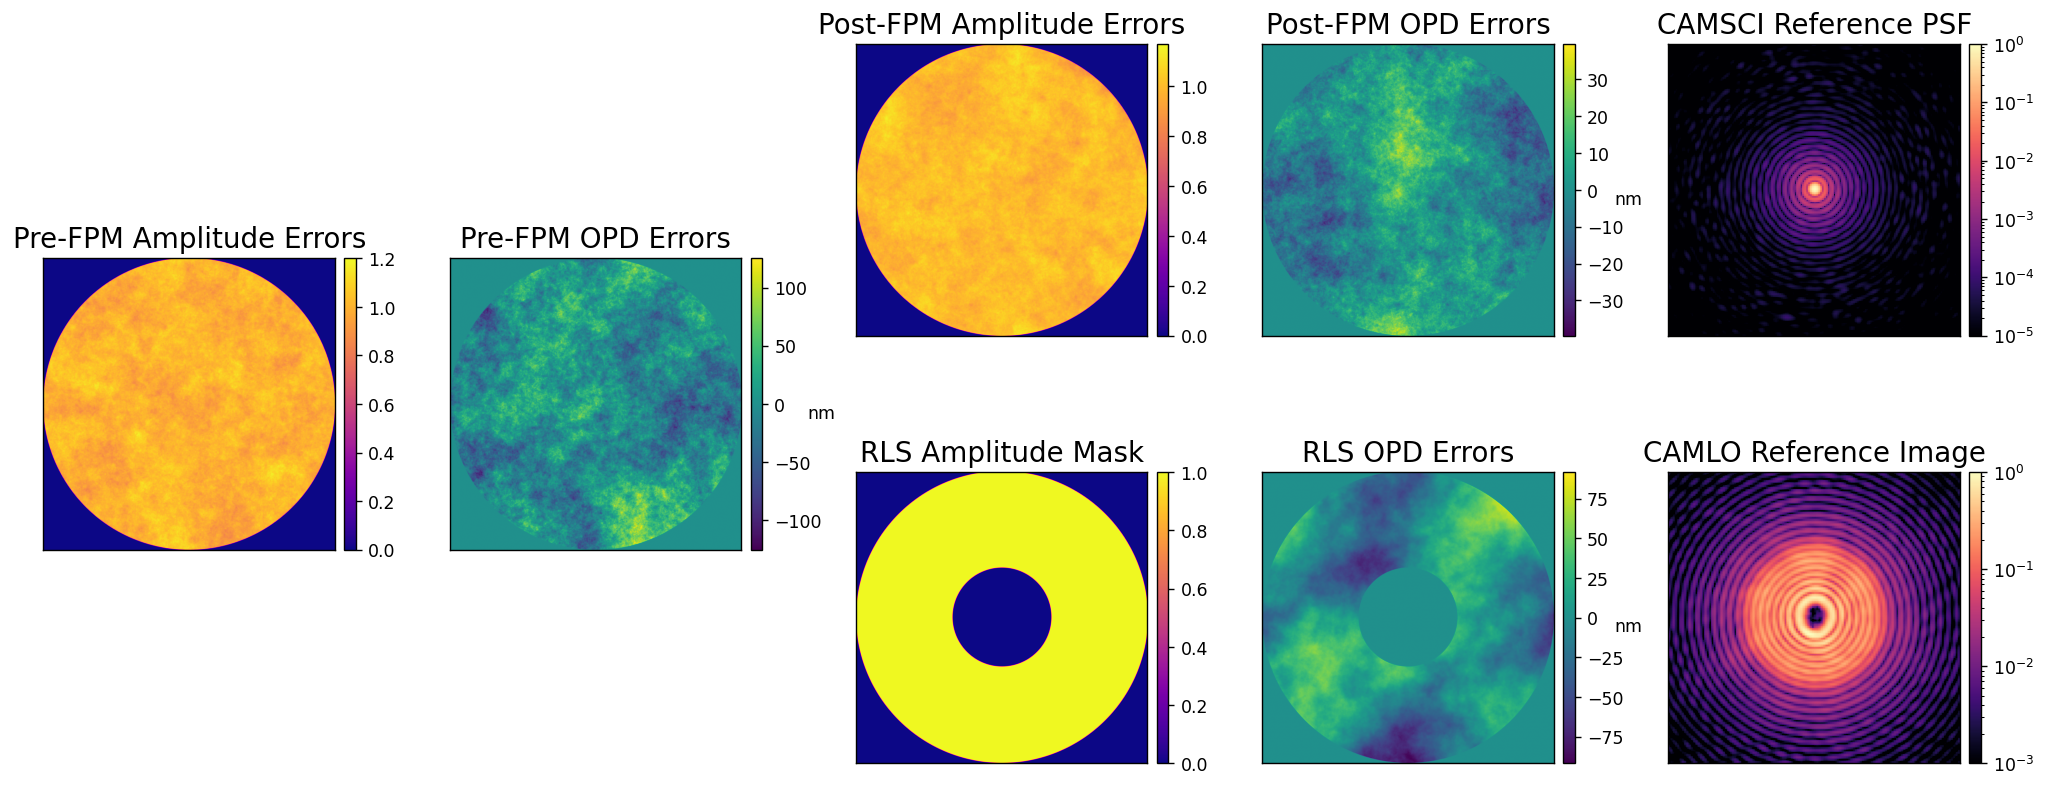

In [17]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, CenteredNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, Normalize

figsize = (20,8)
dpi = 125
title_fz = 16

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(2, 5, figure=fig)

ax = fig.add_subplot(gs[:, 0])
im = ax.imshow(ensure_np_array(M.PREFPM_AMP), cmap='plasma')
ax.set_title('Pre-FPM Amplitude Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)
# ax.set_position([0.05, 0.505, 0.3, 0.3]) 

ax = fig.add_subplot(gs[:, 1])
im = ax.imshow(ensure_np_array(M.PREFPM_OPD)*1e9, cmap='viridis', norm=CenteredNorm())
ax.set_title('Pre-FPM OPD Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=0)
# ax.set_position([0.05, 0.2, 0.3, 0.3]) 

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(ensure_np_array(M.POSTFPM_AMP), cmap='plasma')
ax.set_title('Post-FPM Amplitude Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)
# ax.set_position([0.35, 0.805, 0.15, 0.15]) 

ax = fig.add_subplot(gs[0, 3])
im = ax.imshow(ensure_np_array(M.POSTFPM_OPD)*1e9, cmap='viridis', norm=CenteredNorm())
ax.set_title('Post-FPM OPD Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=3)
# ax.set_position([0.35, 0.50, 0.15, 0.15]) 

# RLS Stuff
ax = fig.add_subplot(gs[1, 2])
im = ax.imshow(ensure_np_array(M.RLS_AMP), cmap='plasma')
ax.set_title('RLS Amplitude Mask', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)

ax = fig.add_subplot(gs[1, 3])
im = ax.imshow(ensure_np_array(M.RLS_OPD)*1e9, cmap='viridis', norm=CenteredNorm())
ax.set_title('RLS OPD Errors', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=3)

ax = fig.add_subplot(gs[0, 4])
im = ax.imshow(ensure_np_array(ref_psf/ref_psf.max()), cmap='magma', norm=LogNorm(vmin=1e-5, vmax=1))
ax.set_title('CAMSCI Reference PSF', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)

ax = fig.add_subplot(gs[1, 4])
im = ax.imshow(ensure_np_array(camlo_im0/camlo_im0.max()), cmap='magma', norm=LogNorm(vmin=1e-3, vmax=1))
ax.set_title('CAMLO Reference Image', fontsize=title_fz)
ax.set_xticks([])
ax.set_yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('nm', rotation=0, labelpad=7)
   
plt.subplots_adjust(wspace=0.3, hspace=0.25)